In [4]:
import csv
import matplotlib.pyplot as plt


def createPerfPlot(csv_file_path: str, csv_file_name: str, title: str):
    # Lists to store data
    x_values = []
    y_values_lists = []

    # Read data from CSV file
    with open(csv_file_path + csv_file_name, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Read the header to get column names

        x_column_index = header.index('M')  # Replace 'x_column_name' with the actual column name for x-axis
        y_column_indices = []
        for i in range(1, len(header)):
            y_column_indices.append(i) 

        for i in range(len(y_column_indices)):
            y_values_lists.append([])

        for row in reader:
            # Extract x-axis values
            x_values.append(float(row[x_column_index]))

            # Extract y-axis values
            for y_index in y_column_indices:
                y_values_lists[y_index - 1].append(float(row[y_index]))        

    colors = ["blue", "green", "orange", "red", "black"]

    plt.figure(figsize=(6, 4))

    # Plot the data
    for i, y_values in enumerate(y_values_lists):
        plt.plot(x_values, y_values, label=header[i + 1], linestyle="-", color=colors[i])

    plt.ylabel('TFLOPS')
    plt.xlabel('Square Matrix Shape (M x M)')
    plt.title(title)

    plt.legend()

    file_name = title.lower().replace(" ", "-")
    save_path = f"{csv_file_path}{file_name}.pdf"
    plt.savefig(save_path, dpi=500, bbox_inches='tight')

    # Display the plot
    plt.show()


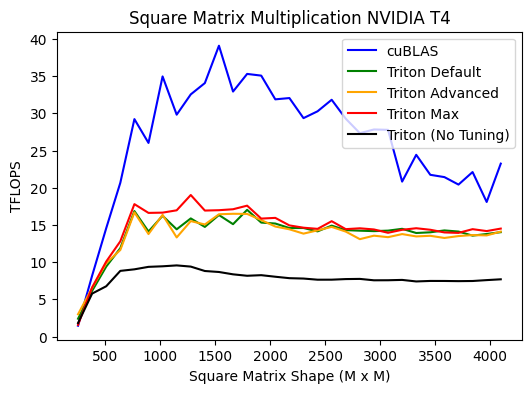

In [8]:
csv_file_path = "Triton/matmul/T4/"
csv_file_name = "restults_tesla_t4.csv"
title = "Square Matrix Multiplication NVIDIA T4"

createPerfPlot(csv_file_path=csv_file_path, csv_file_name=csv_file_name, title=title)

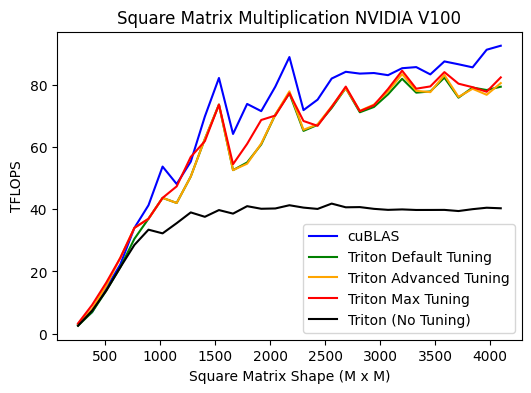

In [9]:
csv_file_path = "Triton/matmul/V100/"
csv_file_name = "restults_volta_V100.csv"
title = "Square Matrix Multiplication NVIDIA V100"

createPerfPlot(csv_file_path=csv_file_path, csv_file_name=csv_file_name, title=title)

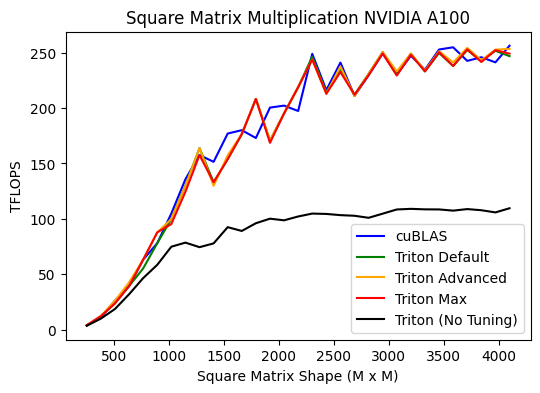

In [10]:
csv_file_path = "Triton/matmul/A100/"
csv_file_name = "results_ampere_A100.csv"
title = "Square Matrix Multiplication NVIDIA A100"

createPerfPlot(csv_file_path=csv_file_path, csv_file_name=csv_file_name, title=title)

In [2]:
def get_average_from_file(file_path: str, remove_first_line: bool):
    with open(file_path, "r") as f: 
        lines = f.readlines()
        if remove_first_line:
            lines.pop(0)
        sum = 0
        for line in lines: 
            line.replace(" ", "")
            sum += float(line)

        return sum/len(lines)

89.52160101358972
102.7522101851504


/var/folders/f1/qxtps1rx3cs85pw03xtp8ql00000gn/T/ipykernel_87273/3674609839.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")
/var/folders/f1/qxtps1rx3cs85pw03xtp8ql00000gn/T/ipykernel_87273/3674609839.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


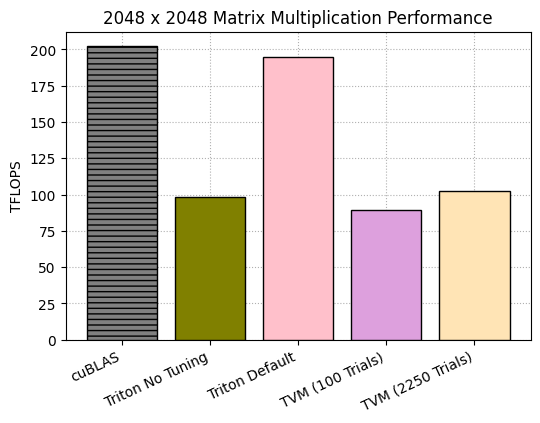

In [12]:
import matplotlib.pyplot as plt

tvm_average_100 = get_average_from_file("TVM-MetaSchedule/matmul/A100/100-trials/benchmark-results-2048x2048.txt", remove_first_line=True)
tvm_average_2250 = get_average_from_file("TVM-MetaSchedule/matmul/A100/2250-trials/benchmark-results-2048x2048.txt", remove_first_line=True)

print(tvm_average_100)
print(tvm_average_2250)

fig, ax = plt.subplots()
fig.set_size_inches(6, 4)

# Plotting the bar chart
ax.bar("cuBLAS", 202.135135, color='grey', edgecolor='black', hatch="---", zorder=3)
ax.bar("Triton No Tuning", 98.689506, color="olive", edgecolor='black', zorder=3)
ax.bar("Triton Default", 195.083907, color="pink", edgecolor='black', zorder=3)
ax.bar("TVM (100 Trials)", tvm_average_100, color="plum", edgecolor='black', zorder=3)
ax.bar("TVM (2250 Trials)", tvm_average_2250, color="moccasin", edgecolor='black', zorder=3)

ax.grid(linestyle="dotted", zorder=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")
ax.set_ylabel('TFLOPS')
ax.set_title("2048 x 2048 Matrix Multiplication Performance")

fig.show()
fig.savefig(fname="TVM-MetaSchedule/matmul/A100/barchart-matmul-perf.pdf", dpi=500, bbox_inches="tight")

In [13]:
batch_sizes = [1, 2, 4, 8, 16, 32, 64]
optimized_name = "results-resnet50-optimized-cuda:0.txt"
unoptimized_name = "results-resnet50-unoptimized-cuda:0.txt"

for batch_size in batch_sizes: 
    print(f"Batch Size {batch_size}")
    file_path = f"Triton/resnet50/A100/Batch-Size-{batch_size}/{optimized_name}"
    optimized_avg = get_average_from_file(file_path=file_path, remove_first_line=False)
    print(f"Average Latency TorchInductor: {optimized_avg}")

    file_path = f"Triton/resnet50/A100/Batch-Size-{batch_size}/{unoptimized_name}"
    unoptimized_avg = get_average_from_file(file_path=file_path, remove_first_line=False)
    print(f"Average Latency PyTorch: {unoptimized_avg}")

    if batch_size == 1: 
        tvm_avg = get_average_from_file("TVM-Ansor/resnet50/A100/benchmark-results.txt", remove_first_line=True)
        tvm_avg *= 1000  # convert to ms
        print(f"Average Latency TVM (Ansor 15,000 Trials): {tvm_avg}")

    print(f"Throughput TorchInductor: {1000/optimized_avg} Images/Second")
    print(f"Throughput PyTorch: {1000/unoptimized_avg} Images/Second")
    
    
    if batch_size == 1:
        print(f"Throughput TVM (Ansor 15.000 Trials): {1000/tvm_avg} Images/Second\n")
    else: 
        print()


Batch Size 1
Average Latency TorchInductor: 3.3306737012863166
Average Latency PyTorch: 7.768932360649108
Average Latency TVM (Ansor 15,000 Trials): 1.5348703990493697
Throughput TorchInductor: 300.2395580250917 Images/Second
Throughput PyTorch: 128.71781521295782 Images/Second
Throughput TVM (Ansor 15.000 Trials): 651.5208063295477 Images/Second

Batch Size 2
Average Latency TorchInductor: 3.4957086772918706
Average Latency PyTorch: 7.76077619791031
Throughput TorchInductor: 286.065027814246 Images/Second
Throughput PyTorch: 128.85309078610757 Images/Second

Batch Size 4
Average Latency TorchInductor: 4.3171696224212655
Average Latency PyTorch: 8.100554756641388
Throughput TorchInductor: 231.63324294845623 Images/Second
Throughput PyTorch: 123.44833533532153 Images/Second

Batch Size 8
Average Latency TorchInductor: 6.586083315849305
Average Latency PyTorch: 9.851685884952545
Throughput TorchInductor: 151.8353097042541 Images/Second
Throughput PyTorch: 101.50546938645283 Images/Second

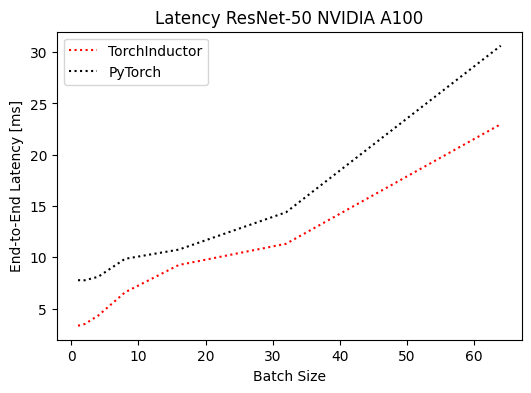

In [6]:
import matplotlib.pyplot as plt

title = "Latency ResNet-50 NVIDIA A100"
batch_sizes = [1, 2, 4, 8, 16, 32, 64]
inductor_name = "results-resnet50-optimized-cuda:0.txt"
torch_name = "results-resnet50-unoptimized-cuda:0.txt"

inductor_averages = []
torch_averages = []


for batch_size in batch_sizes: 
    file_path = f"Triton/resnet50/A100/Batch-Size-{batch_size}/{inductor_name}"
    inductor_averages.append(get_average_from_file(file_path=file_path, remove_first_line=False))

    file_path = f"Triton/resnet50/A100/Batch-Size-{batch_size}/{torch_name}"
    torch_averages.append(get_average_from_file(file_path=file_path, remove_first_line=False))

labels = ["TorchInductor", "PyTorch"]
y_values_lists = [inductor_averages, torch_averages]

colors = ["red", "black"]
plt.figure(figsize=(6, 4))

# Plot the data
for i, y_values in enumerate(y_values_lists):
    plt.plot(batch_sizes, y_values, label=labels[i], linestyle="dotted", color=colors[i])

plt.ylabel("End-to-End Latency [ms]")
plt.xlabel("Batch Size")
plt.title(title)
plt.legend()
file_name = title.lower().replace(" ", "-")
save_path = f"Triton/resnet50/A100/{file_name}.pdf"
plt.savefig(save_path, dpi=500, bbox_inches='tight')

# Display the plot
plt.show()
